For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Justin Lau, David Yei__

## Step 1: Word2Vec paper questions

#### Describe how a CBOW word embedding is generated.

A CBOW word embedding is generated by building a log-linear classifier using a current word (the target word) and its surrounding words (input). The task is to predict the “middle” word given its context. In the paper, the authors looked at a window of 4 words before and after the target word.

#### What is a CBOW word embedding and how is it different from a skip-gram word embedding?

The CBOW word embedding is similar to the feed forward NNLM, such that the non-linear hidden layer is removed and the projection layer is shared for all words so that all words get projected into the same position. It is essentially a vector generated by transforming sequences of words into its respective numerical representations. This embedding differs from a skip-gram word embedding because the CBOW word embedding takes context into account, whereas a standard bag-of-words model only keeps track of word frequency.

#### What is the task that the authors use to evaluate the generated word embeddings?

The authors use a word similarity task to evaluate the generated word embeddings. They evaluate the performance on 5 semantic relationship questions (such as currency and capital cities) and 9 syntactic relationship questions (such as opposites, plural nouns, and past tense). By using the generated word embeddings, the authors can use algebraic operations on these vector representations to find similar words. For instance, the authors state that “To find a word that is similar to small in the same sense as biggest is similar to big, we can simply compute vector X = vector("biggest") - vector("big") + vector("small")”.
    
#### What are PCA and t-SNE? Why are these important to the task of training and interpreting word embeddings?

PCA stands for Principal Component Analysis, a tool that reduces the amount of dimensions in data. Operating in higher dimensions requires more computational power, and oftentimes humans cannot visualize data past three dimensions. As a result, PCA projects the data into less dimensions so that the information is preserved, but also easier to understand. This is important for understanding word embeddings, and will also simplify the training of such embeddings. 
Furthermore, t-SNE stands for t-Distributed Stochastic Neighbor Embedding. This unsupervised task is also useful in visualizing data expressed in high dimensions. As a result t-SNE would be extremely useful for visualizing our generated embeddings, which allows us to understand our data better. In fact, t-SNE mitigates the weakness of PCA because PCA is a linear algorithm. Thus, PCA will not be able to visualize the polynomial relationships between features well.


Step 2: Train your own word embeddings
--------------------------------

Spooky Authors Dataset Description: This data contains sentences from the works of many famous authors: Edgar Allan Poe, HP Lovecraft, and Mary Shelley. These authors are famous for their "spooky" works. Each row in the .csv file contained an ID, a sentence, and the author (abbreviated). For our word embedding generation and sentence generation task, we only need the sentence column.

Describe what data set you have chosen to compare and contrast with the Spooky Authors Dataset. Make sure to describe where it comes from and it's general properties.

The dataset we have chosen to compare and contrast with the Spooky Authors Dataset is a collection of lyrics from popular artists. For instance, some artists include Kanye West, Rihanna, Bruno Mars, and Justin Bieber. The dataset can be found on Kaggle: https://www.kaggle.com/paultimothymooney/poetry. I combined the .txt files into a single .csv file for convenience.

In [1]:
import pandas as pd
import gensim
import nltk
import re
import string
import random
import numpy as np
import scipy
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from unidecode import unidecode
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Justin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### a) Train embeddings on GIVEN dataset

In [2]:
#read in our spooky author .csv file and save it as a dataframe
author_df = pd.read_csv('train.csv')
author_df.head(10)

,text
0,"This process, however, afforded me no means of..."
1,It never once occurred to me that the fumbling...
2,"In his left hand was a gold snuff box, from wh..."
3,How lovely is spring As we looked from Windsor...
4,"Finding nothing else, not even gold, the Super..."
5,"A youth passed in solitude, my best years spen..."
6,"The astronomer, perhaps, at this point, took r..."
7,The surcingle hung in ribands from my body.
8,I knew that you could not say to yourself 'ste...
9,I confess that neither the structure of langua...


In [3]:
#this function normalizes the encoding of the text, removes punctuation,
# and preprocesses the text by prepending <s> and appending </s>
def preprocess(s):
    s = unidecode(s)
    for c in string.punctuation:
        s = s.replace(c, "")
    s = "<s> " + s + " </s>"
    return s

#this function tokenizes a sentence by splitting on whitespace
def word_tokenize(sentence):
    return sentence.split()

#apply our preprocess function on our text column
author_df["text"] = author_df["text"].apply(preprocess)

author_df.head(10)

,text
0,<s> This process however afforded me no means ...
1,<s> It never once occurred to me that the fumb...
2,<s> In his left hand was a gold snuff box from...
3,<s> How lovely is spring As we looked from Win...
4,<s> Finding nothing else not even gold the Sup...
5,<s> A youth passed in solitude my best years s...
6,<s> The astronomer perhaps at this point took ...
7,<s> The surcingle hung in ribands from my body...
8,<s> I knew that you could not say to yourself ...
9,<s> I confess that neither the structure of la...


In [4]:
#create a new column that tokenizes each sentence in the text column into a list of strings
author_df["tokenized"] = author_df["text"].apply(word_tokenize)
author_df.head(10)

,text,tokenized
0,<s> This process however afforded me no means ...,"[<s>, This, process, however, afforded, me, no..."
1,<s> It never once occurred to me that the fumb...,"[<s>, It, never, once, occurred, to, me, that,..."
2,<s> In his left hand was a gold snuff box from...,"[<s>, In, his, left, hand, was, a, gold, snuff..."
3,<s> How lovely is spring As we looked from Win...,"[<s>, How, lovely, is, spring, As, we, looked,..."
4,<s> Finding nothing else not even gold the Sup...,"[<s>, Finding, nothing, else, not, even, gold,..."
5,<s> A youth passed in solitude my best years s...,"[<s>, A, youth, passed, in, solitude, my, best..."
6,<s> The astronomer perhaps at this point took ...,"[<s>, The, astronomer, perhaps, at, this, poin..."
7,<s> The surcingle hung in ribands from my body...,"[<s>, The, surcingle, hung, in, ribands, from,..."
8,<s> I knew that you could not say to yourself ...,"[<s>, I, knew, that, you, could, not, say, to,..."
9,<s> I confess that neither the structure of la...,"[<s>, I, confess, that, neither, the, structur..."


In [5]:
lemmatizer = WordNetLemmatizer()

#preprocesses the tokenized list of strings by lemmatizing each string and converting it to lowercase
def preprocess_tokenized(los):
    result = []
    for s in los:
        result.append(lemmatizer.lemmatize(s.lower()))
    return result

author_df["tokenized"] = author_df["tokenized"].apply(preprocess_tokenized)
author_df.head(10)

,text,tokenized
0,<s> This process however afforded me no means ...,"[<s>, this, process, however, afforded, me, no..."
1,<s> It never once occurred to me that the fumb...,"[<s>, it, never, once, occurred, to, me, that,..."
2,<s> In his left hand was a gold snuff box from...,"[<s>, in, his, left, hand, wa, a, gold, snuff,..."
3,<s> How lovely is spring As we looked from Win...,"[<s>, how, lovely, is, spring, a, we, looked, ..."
4,<s> Finding nothing else not even gold the Sup...,"[<s>, finding, nothing, else, not, even, gold,..."
5,<s> A youth passed in solitude my best years s...,"[<s>, a, youth, passed, in, solitude, my, best..."
6,<s> The astronomer perhaps at this point took ...,"[<s>, the, astronomer, perhaps, at, this, poin..."
7,<s> The surcingle hung in ribands from my body...,"[<s>, the, surcingle, hung, in, riband, from, ..."
8,<s> I knew that you could not say to yourself ...,"[<s>, i, knew, that, you, could, not, say, to,..."
9,<s> I confess that neither the structure of la...,"[<s>, i, confess, that, neither, the, structur..."


In [6]:
#initialize our sentences to be fed into our Word2Vec model
sentences = author_df["tokenized"].tolist()
print(len(sentences))

19579


In [7]:
from gensim.models import Word2Vec

# The dimension of word embedding. 
# This variable will be used throughout the program
# you may vary this as you desire
EMBEDDINGS_SIZE = 200

# Train the Word2Vec model from Gensim. 
# Below are the hyperparameters that are most relevant. 
# But feel free to explore other 
# options too:
# sg = 1
# window = 5
# size = EMBEDDING_SIZE
# min_count = 1

#initialize the model
model1 = Word2Vec(sentences, size=EMBEDDINGS_SIZE, window=5, min_count=1, sg=1)

In [8]:
#ensure that our word vector functions properly
vectors1 = model1.wv
print(vectors1.similarity("dungeon", "man"))
vectors1.most_similar("the")

0.65130687


[('whole', 0.7999961376190186),
 ('shunned', 0.785700798034668),
 ('town', 0.779183566570282),
 ('college', 0.7780133485794067),
 ('spring', 0.7771700620651245),
 ('various', 0.7756372690200806),
 ('gloomy', 0.7750914096832275),
 ('full', 0.7738213539123535),
 ('coming', 0.7713671326637268),
 ('upper', 0.7711132764816284)]

In [9]:
# if you save your Word2Vec as the variable model, this will 
# print out the vocabulary size
print('Vocab size {}'.format(len(model1.wv.vocab)))

Vocab size 22309


In [10]:
# You can save file in txt format, then load later if you wish.
model1.wv.save_word2vec_format('embeddings.txt', binary=False)

### b) Train embedding on YOUR dataset

In [11]:
#read in our lyrics dataset to a dataframe
merged_df = pd.read_csv('lyrics.csv')
merged_df.head(10)

,text
0,Looking for some education
1,Made my way into the night
2,All that bullshit conversation
3,"Baby, can't you read the signs? I won't bore y..."
4,I don't even wanna waste your time
5,Let's just say that maybe
6,You could help me ease my mind
7,I ain't Mr. Right But if you're looking for fa...
8,If that's love in your eyes
9,It's more than enough


In [12]:
merged_df["text"] = merged_df["text"].apply(preprocess)
merged_df.head(10)

,text
0,<s> Looking for some education </s>
1,<s> Made my way into the night </s>
2,<s> All that bullshit conversation </s>
3,<s> Baby cant you read the signs I wont bore y...
4,<s> I dont even wanna waste your time </s>
5,<s> Lets just say that maybe </s>
6,<s> You could help me ease my mind </s>
7,<s> I aint Mr Right But if youre looking for f...
8,<s> If thats love in your eyes </s>
9,<s> Its more than enough </s>


In [13]:
merged_df["tokenized"] = merged_df["text"].apply(word_tokenize)
merged_df.head(10)

,text,tokenized
0,<s> Looking for some education </s>,"[<s>, Looking, for, some, education, </s>]"
1,<s> Made my way into the night </s>,"[<s>, Made, my, way, into, the, night, </s>]"
2,<s> All that bullshit conversation </s>,"[<s>, All, that, bullshit, conversation, </s>]"
3,<s> Baby cant you read the signs I wont bore y...,"[<s>, Baby, cant, you, read, the, signs, I, wo..."
4,<s> I dont even wanna waste your time </s>,"[<s>, I, dont, even, wanna, waste, your, time,..."
5,<s> Lets just say that maybe </s>,"[<s>, Lets, just, say, that, maybe, </s>]"
6,<s> You could help me ease my mind </s>,"[<s>, You, could, help, me, ease, my, mind, </s>]"
7,<s> I aint Mr Right But if youre looking for f...,"[<s>, I, aint, Mr, Right, But, if, youre, look..."
8,<s> If thats love in your eyes </s>,"[<s>, If, thats, love, in, your, eyes, </s>]"
9,<s> Its more than enough </s>,"[<s>, Its, more, than, enough, </s>]"


In [14]:
merged_df["tokenized"] = merged_df["tokenized"].apply(preprocess_tokenized)
merged_df.head(10)

,text,tokenized
0,<s> Looking for some education </s>,"[<s>, looking, for, some, education, </s>]"
1,<s> Made my way into the night </s>,"[<s>, made, my, way, into, the, night, </s>]"
2,<s> All that bullshit conversation </s>,"[<s>, all, that, bullshit, conversation, </s>]"
3,<s> Baby cant you read the signs I wont bore y...,"[<s>, baby, cant, you, read, the, sign, i, won..."
4,<s> I dont even wanna waste your time </s>,"[<s>, i, dont, even, wanna, waste, your, time,..."
5,<s> Lets just say that maybe </s>,"[<s>, let, just, say, that, maybe, </s>]"
6,<s> You could help me ease my mind </s>,"[<s>, you, could, help, me, ease, my, mind, </s>]"
7,<s> I aint Mr Right But if youre looking for f...,"[<s>, i, aint, mr, right, but, if, youre, look..."
8,<s> If thats love in your eyes </s>,"[<s>, if, thats, love, in, your, eye, </s>]"
9,<s> Its more than enough </s>,"[<s>, it, more, than, enough, </s>]"


In [15]:
sentences = merged_df["tokenized"].tolist()
print(len(sentences))

82025


In [16]:
model2 = Word2Vec(sentences, size=EMBEDDINGS_SIZE, window=5, min_count=1, sg=1)
vectors2 = model2.wv

In [17]:
print(vectors2.similarity("hello", "hey"))
vectors2.most_similar("nobody")

0.685649


[('wantwant', 0.7478058338165283),
 ('else', 0.7379727363586426),
 ('quite', 0.7362951040267944),
 ('nothin', 0.736271858215332),
 ('dynamite', 0.73493891954422),
 ('marshall', 0.7323717474937439),
 ('anymore', 0.7300677299499512),
 ('pastor', 0.7293627262115479),
 ('hesitate', 0.725982666015625),
 ('anyone', 0.7145913243293762)]

In [18]:
print('Vocab size {}'.format(len(model2.wv.vocab)))

Vocab size 16992


In [19]:
model2.wv.save_word2vec_format('lyric_embeddings.txt', binary=False)

__What text-normalization and pre-processing did you do and why?__ We lemmatized the tokens so that words that would be used in the same context (adequate and adequately) would be mapped to the same word, and possibly have better results when evaluating cosine similarity. We also removed punctuation so that tokens (adequate, vs. adequate) would be mapped to the same token, which may improve results. Furthermore, we converted each word to lowercase in order to normalize the text. Lastly, we added "\<s>" to the beginning of the sentence and "\</s>" to the end of the sentence to help us with sentence generation.

Step 3: Evaluate the differences between the word embeddings
----------------------------

(make sure to include graphs, figures, and paragraphs with full sentences)

In [20]:
#create a dataframe of model1's (spooky author) vocab and its embeddings
X=model1[model1.wv.vocab]
df=pd.DataFrame(X)
df.head()

C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.173811,-0.385638,-0.009694,-0.183743,0.061469,0.304819,0.067464,-0.138385,0.148297,-0.094668,...,0.006540,-0.279017,-0.073478,0.092983,0.071952,-0.458964,0.408963,-0.311668,0.139038,0.277081
1,0.308776,-0.266358,0.014379,-0.114573,-0.101914,0.177850,-0.237990,0.115552,0.271887,0.107870,...,-0.196647,-0.103092,0.076639,0.272038,-0.078331,-0.212322,0.506464,-0.392360,-0.085395,0.176916
2,0.090247,-0.198025,-0.106492,-0.064108,-0.002446,0.107317,-0.069703,0.011900,0.175634,0.097579,...,-0.220635,-0.061695,0.082535,0.009829,0.013276,-0.132774,0.261001,-0.200589,-0.017266,0.074063
3,0.192338,-0.243833,0.007396,-0.264072,-0.164524,0.131691,-0.081351,0.030211,0.192706,0.104744,...,-0.309392,-0.238394,-0.102475,0.077679,-0.027573,-0.303575,0.569480,-0.321141,0.102886,0.100907
4,0.050485,-0.312051,0.037013,-0.117584,-0.060653,0.204513,-0.107602,0.057644,0.165385,0.120281,...,-0.174645,-0.115378,0.132297,-0.009963,-0.051676,-0.109997,0.209205,-0.046046,0.004756,0.084963


In [21]:
#create a dataframe of model2's (lyrics) vocab and its embeddings
X2=model2[model2.wv.vocab]
df_2=pd.DataFrame(X2)
df_2.head()

C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.184117,-0.174573,0.021446,0.153294,0.389276,0.613656,0.257695,-0.016269,0.115841,0.017907,...,0.065550,0.065850,-0.148861,0.036243,-0.098314,0.121541,-0.036893,0.104349,-0.114206,0.056790
1,0.174940,-0.207648,-0.091601,0.264879,-0.019100,0.071848,0.324536,-0.003449,-0.114948,0.229059,...,0.197213,0.457769,0.402507,-0.071177,-0.029087,0.377202,0.244511,-0.091474,0.054364,0.294898
2,0.189299,0.363365,-0.043875,-0.055484,0.194635,-0.134377,-0.053913,0.085214,0.240203,0.287543,...,0.260646,0.206221,-0.016245,-0.115650,-0.027094,0.269091,0.140548,0.052047,0.261077,-0.101028
3,0.194492,-0.191445,-0.060625,0.281692,0.256917,0.115851,0.043581,0.175294,-0.115904,0.240437,...,0.360706,-0.134930,0.492069,0.010386,-0.331078,-0.116569,-0.066425,0.299412,0.218405,-0.009419
4,0.004320,-0.063277,0.012002,-0.015538,0.042776,-0.025556,0.046442,-0.024462,0.015558,0.045159,...,0.018541,0.053107,0.015337,-0.029431,0.006651,0.017021,0.051849,-0.003290,-0.032502,0.037883


In [22]:
#Computing the correlation matrix
X_corr=df.corr()
X_corr

#Computing eigenvalues and eigenvectors
values1,vectors1=np.linalg.eig(X_corr)

#Sorting the eigenvectors coresponding to eigenvalues in descending order
args1 = (-values1).argsort()
values1 = vectors1[args1]
vectors1 = vectors1[:, args1]

#Taking first 2 components which explain maximum variance for projecting
new_vectors1=vectors1[:,:2]

#Projecting it onto new dimension with 2 axis
neww_X=np.dot(X,new_vectors1)

In [23]:
#Computing the correlation matrix
X2_corr=df_2.corr()

#Computing eigen values and eigen vectors
values2,vectors2=np.linalg.eig(X2_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args2 = (-values2).argsort()
values2 = vectors2[args2]
vectors2 = vectors2[:, args2]

#Taking first 2 components which explain maximum variance for projecting
new_vectors2=vectors2[:,:2]

#Projecting it onto new dimension with 2 axis
neww_X_2=np.dot(X2,new_vectors2)

Text(0.5, 1.0, 'Word Embedding Space (Spooky Authors)')

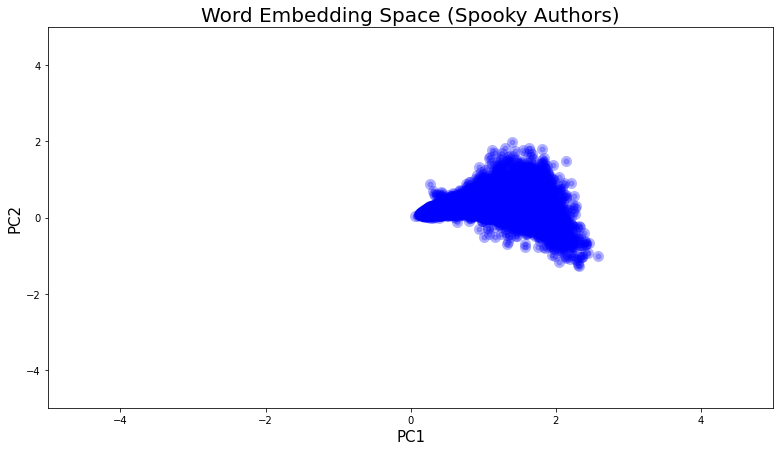

In [24]:
#Create a figure illlustrating the word embedding space of spooky authors dataset
plt.figure(figsize=(13,7))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=5,color='blue',alpha=0.3)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Word Embedding Space (Spooky Authors)",size=20)


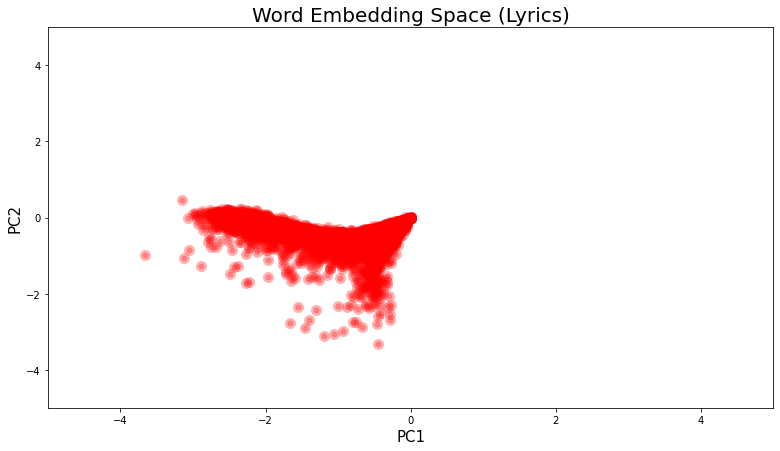

In [25]:
#Create a figure illlustrating the word embedding space of lyrics dataset
plt.figure(figsize=(13,7))
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title("Word Embedding Space (Lyrics)",size=20)
plt.scatter(neww_X_2[:,0],neww_X_2[:,1],linewidths=5,color='red',alpha=0.3)

In [26]:
#find the overlap in vocab and choose a random 50 words from it
same_vocabs = [word for word in model1.wv.vocab.keys() if word in model2.wv.vocab.keys() and len(word) >= 3]
random_words = random.sample(same_vocabs, 50)

In [27]:
#filter the vocab from our models so that we only plot 50 words and their embeddings
filtered_vocab1 = {key: value for key, value in model1.wv.vocab.items() if key in random_words}
filtered_vocab2 = {key: value for key, value in model2.wv.vocab.items() if key in random_words}

In [28]:
#create a dataframe from model1's (spooky author) filtered vocab
X3=model1[filtered_vocab1]
df3=pd.DataFrame(X3)
df3.head()

C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.073054,-0.303081,-0.127414,-0.079448,-0.060086,0.045622,-0.050900,-0.010990,0.117457,0.223921,...,-0.197459,0.007060,-0.017209,0.057870,-0.003058,-0.105340,0.280888,-0.173812,-0.095554,0.104639
1,0.069393,-0.073483,-0.061884,-0.077640,-0.091383,0.256162,-0.188154,0.300240,0.103980,0.263970,...,-0.272354,-0.041752,0.340968,0.172764,-0.106980,-0.119278,-0.014669,-0.031898,0.061433,0.347216
2,0.013972,-0.112218,-0.145596,0.037214,-0.056473,0.042467,-0.141511,0.080592,0.154667,0.178938,...,-0.285579,0.059815,0.126913,0.020306,0.069885,-0.125073,0.201057,-0.248982,-0.083883,0.229426
3,0.028479,-0.281307,-0.099298,-0.062133,-0.075353,0.130150,-0.153380,0.034097,0.129835,0.181458,...,-0.280818,-0.070157,0.083460,0.087183,-0.002093,-0.113146,0.172093,-0.157856,-0.047508,0.148420
4,0.040514,-0.127826,-0.093190,-0.035765,-0.001409,0.055384,-0.066528,0.017582,0.156274,0.090183,...,-0.205869,0.009310,0.152871,-0.020618,0.054879,-0.111684,0.158270,-0.147190,-0.037755,0.121407


In [29]:
#create a dataframe from model2's (lyrics) filtered vocab
X4=model2[filtered_vocab2]
print(type(filtered_vocab2))
df4=pd.DataFrame(X4)
print(df4.shape)
df4.head()


<class 'dict'>
(50, 200)


C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.306843,-0.328125,-0.342161,-0.344343,0.140201,0.420177,0.114792,-0.231906,0.179828,0.169683,...,0.211479,0.069284,0.062856,0.113243,-0.100076,-0.019584,0.280583,-0.198895,-0.240303,-0.197169
1,0.002560,-0.206826,0.034494,0.088852,0.270254,0.258828,0.079422,-0.037731,-0.069336,0.273769,...,-0.090116,0.053910,0.140040,-0.054386,-0.231298,-0.161009,0.213906,0.034694,-0.010584,0.362892
2,0.116365,-0.146896,0.246907,-0.114917,-0.260540,0.147306,0.311030,-0.200401,-0.143660,0.353622,...,0.065029,0.412557,0.073905,-0.197103,-0.304452,-0.148418,0.364683,-0.055193,-0.052653,0.293317
3,-0.056163,-0.174295,0.041879,0.027325,0.127416,0.128352,0.149919,-0.186394,-0.043643,0.307686,...,0.036501,0.213465,0.067089,-0.106493,-0.043766,0.059259,0.124954,0.115053,0.020088,0.128947
4,0.093863,-0.300656,-0.013405,0.078001,0.073449,0.198836,0.215801,-0.414640,-0.226097,0.426844,...,0.288490,0.305507,0.008963,0.052748,-0.256736,0.065912,0.083736,0.255671,0.025211,0.224100


In [30]:
#Computing the correlation matrix
X3_corr=df3.corr()

#Computing eigen values and eigen vectors
values3,vectors3=np.linalg.eig(X3_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args3 = (-values3).argsort()
values3 = vectors3[args3]
vectors3 = vectors3[:, args3]

#Taking first 2 components which explain maximum variance for projecting
new_vectors3=vectors3[:,:2]

#Projecting it onto new dimension with 2 axis
neww_X_3=np.dot(X3,new_vectors3)

In [31]:
#Computing the correlation matrix
X4_corr=df4.corr()

#Computing eigen values and eigen vectors
values4,vectors4=np.linalg.eig(X4_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args4 = (-values4).argsort()
values4 = vectors4[args4]
vectors4 = vectors4[:, args4]

#Taking first 2 components which explain maximum variance for projecting
new_vectors4=vectors4[:,:2]

#Projecting it onto new dimension with 2 axis
neww_X_4=np.dot(X4,new_vectors4)

C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\text.py:1344: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\text.py:1346: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\text.py:822: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\text.py:823: ComplexWarning: Casting complex v

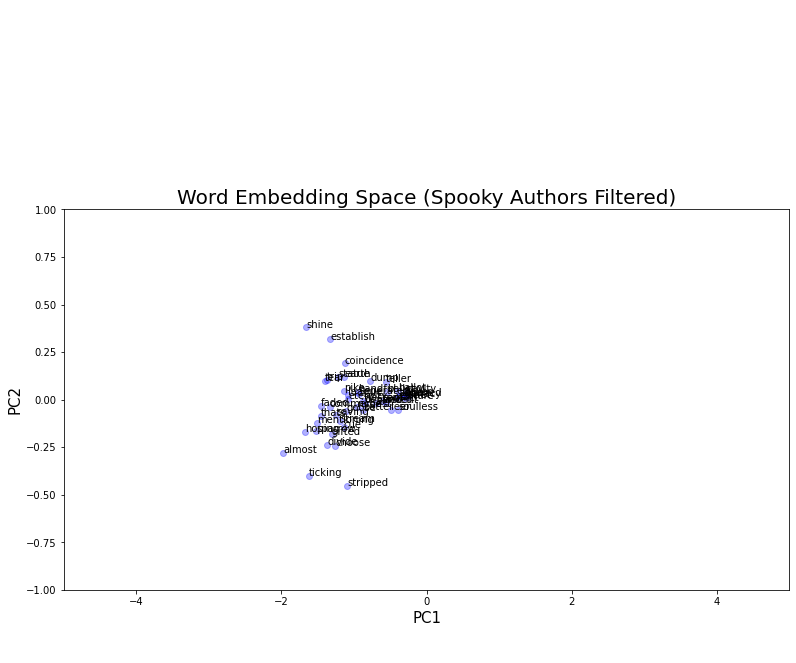

In [32]:
#Create a figure illlustrating the word embedding space of filtered spooky authors dataset
plt.figure(figsize=(13,7))
plt.scatter(neww_X_3[:,0],neww_X_3[:,1],linewidths=1,color='blue',alpha=0.3)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.title("Word Embedding Space (Spooky Authors Filtered)",size=20)
vocab=list(filtered_vocab2)
for i, word in enumerate(vocab):
    plt.annotate(word,xy=(neww_X_3[i,0],neww_X_3[i,1]))

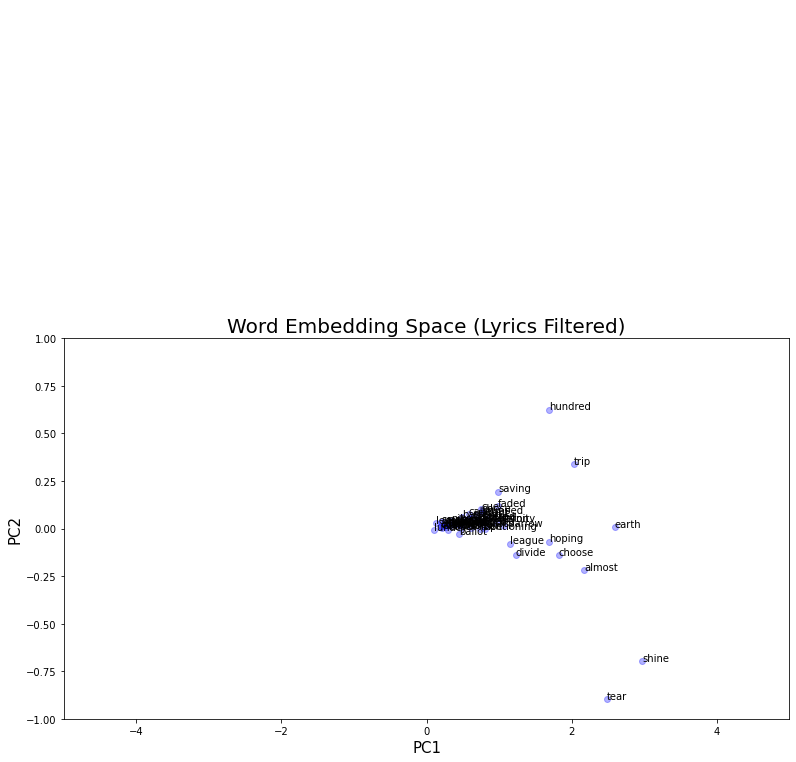

In [33]:
#Create a figure illlustrating the word embedding space of filtered lyrics dataset
plt.figure(figsize=(13,7))
plt.scatter(neww_X_4[:,0],neww_X_4[:,1],linewidths=1,color='blue',alpha=0.3)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.xlim(-5, 5)
plt.ylim(-1, 1)
plt.title("Word Embedding Space (Lyrics Filtered)",size=20)
vocab=list(filtered_vocab2)
for i, word in enumerate(vocab):
    plt.annotate(word,xy=(neww_X_4[i,0],neww_X_4[i,1]))

0.5365830199781819


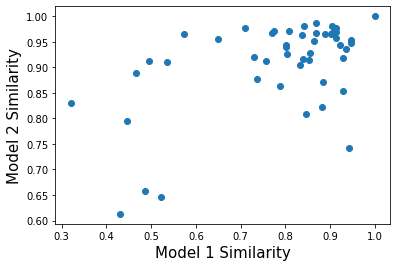

In [34]:
#illustrate similarity of one word compared to the rest of the words in random_words
similarities1 = []
similarities2 = []
for w in random_words:
    similarities1.append(model1.wv.similarity(word, w))
    similarities2.append(model2.wv.similarity(word, w))
similarities1 = similarities1[1:]
similarities2 = similarities2[1:]

#calculate correlation of these similarties
plt.scatter(similarities2, similarities1, label='train')
plt.xlabel("Model 1 Similarity",size=15)
plt.ylabel("Model 2 Similarity",size=15)
correlation, p_value = scipy.stats.pearsonr(similarities1, similarities2)
print(correlation)

## Comparing the Word Embeddings:

The models we trained on different data sets resulted in different embeddings, as you can see above. We trained our first model on the spooky authors dataset, and we trained our second model on the lyrics dataset. Since the two datasets have different vocabularies, we picked 50 random words that appeared in both corpora, and did visualization based on these 50 common words.

We used a technique called PCA. We first compute the correlation matrix of the 50 words embeddings, and then we calculate its eigenvectors and eigenvalues using eigen decomposition, and then we sort eigenvalues and their corresponding eigenvectors. We then pick the top two eigenvalues and create a matrix of 50 eigenvectors, and we eventually transform the original data using dot product with these new eigenvectors. This way we are projecting 50 dimension embeddings to 2 dimension, which can be easily visualized. We can see for model 1 (the spooky author dataset), a lot of the embeddings are staggered towards the positive x-axis, while for model 2 a lot of the embeddings are staggered towards the negative x-axis. This might be due to the same word being used under different contexts. Some words, for example ocean, have similar embeddings, which might be because 'ocean' is a relatively neutral word so it's used the same way in both contexts. Meanwhile other words can be more dependent on the contexts it's used in.

We also took one word from the 50 random words, and compared similarity with the rest 49 words. We stored the similarities for both models, and plotted a scatter plot. We then found a correlation coefficient of 0.36. Theoretically, the two should be positively correlated since two words should have the same similarity. However, since we are using very different corporus, one is a authors writting horror novels, another are modern pop and rap song lyrics, it makes sense that the embeddings for the words are very different, since the language use in the respective disciplines can be very different.

Cite your sources:
-------------

https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354

Step 4: Feedforward Neural Language Model
--------------------------

### a) First, encode  your text into integers

In [35]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

NGRAM = 3 # The size of the ngram language model you want to train

# Initializing a Tokenizer
# It is used to vectorize a text corpus. Here, it just creates a mapping from 
# word to a unique index. (Note: Indexing starts from 0)
# Example:
def encode_text_to_int(file):
    f = open(file, "r", encoding="utf8")
    data = f.readlines()

    for i in range(len(data)):
        data[i] = preprocess_tokenized(word_tokenize(preprocess(data[i])))


    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    encoded = tokenizer.texts_to_sequences(data)
    word_index = tokenizer.word_index
    
    return encoded, word_index


### b) Next, prepare your sequences from text

#### Fixed ngram based sequences (Used for Feedforward)

In [36]:
#makes list of ngrams given a list of tokens and n (number of grams)
def make_ngrams(tokens, n):
    result = []
    for i in range(len(tokens) - n + 1):
        result.append(tokens[i:i+n])
    return result


def generate_ngram_training_samples(encoded, num_n_grams) -> list:
    result = []
    for tokens in encoded:
        n_grams = make_ngrams(tokens, num_n_grams)
        result.extend(n_grams)
    '''
    Takes the encoded data (list of lists) and 
    generates the training samples out of it.
    Parameters:
    up to you, we've put in what we used
    but you can add/remove as needed
    return: 
    list of lists in the format [[x1, x2, ... , x(n-1), y], ...]
    '''
    return result



### c) Then, split the sequences into X and y and create a Data Generator

In [37]:
# Note here that the sequences were in the form: 
# sequence = [x1, x2, ... , x(n-1), y]
# We still need to separate it into [[x1, x2, ... , x(n-1)], ...], [y1, y2, ...]
def split_X_y(samples):
    split_n_grams = []
    split_predicted = []
    for sample in samples:
        split_n_grams.append(sample[0:len(sample)-1])
        split_predicted.append(sample[-1])

    return split_n_grams, split_predicted



In [38]:
def read_embeddings(file, word_index):
    '''Loads and parses embeddings trained in earlier.
    Parameters and return values are up to you.
    '''
    f = open(file, "r", encoding="utf8")
    embeddings = f.readlines()
    f.close()
    
    embeddings.remove(embeddings[0])
    word_2_embeddings = {}
    index_2_embeddings = {}
    for line in embeddings:
        los = line.split()
        lofloats = [float(s) for s in los[1:]]
        word_2_embeddings[los[0]] = lofloats
        index_2_embeddings[word_index[los[0].lower()]] = lofloats
    return word_2_embeddings, index_2_embeddings




In [39]:
def data_generator(X: list, y: list, num_sequences_per_batch: int, i2e) -> (list,list):
    '''
    Returns data generator to be used by feed_forward
    https://wiki.python.org/moin/Generators
    https://realpython.com/introduction-to-python-generators/
    
    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 
    (see the to_categorical function)
    
    '''
    X_batch = []
    y_batch = []
    y = [num - 1 for num in y]
    while(True):
        for i, val in enumerate(X):
            if len(X_batch) == num_sequences_per_batch:
                yield np.array(X_batch), np.array(y_batch)
                X_batch = []
                y_batch = []
            else:
                single_X_batch = np.array([i2e[v] for v in val]).flatten()
                single_y_batch = np.array(to_categorical(y[i], num_classes = len(i2e.keys())))
                X_batch.append(single_X_batch)
                y_batch.append(single_y_batch)
    



### d) Train your models

In [40]:
#initializes a feedforward model given a text file, n_grams, its embeddings, and the number of sequences per batch
def init_feedforward(text_file, n_grams, embedding_file, num_sequences_per_batch):
    #encode the text file into integers
    encoded, word_index = encode_text_to_int(text_file)
    #generate training samples that the model will be fitted on
    n_gram_training_samples = generate_ngram_training_samples(encoded, n_grams)
    steps_per_epoch = len(n_gram_training_samples) // num_sequences_per_batch
    #useful dictionaries to generate data and create sentences
    w2e, i2e = read_embeddings(embedding_file, word_index)
    #split the data into ngram and its "label"
    split_n_grams, split_predicted = split_X_y(n_gram_training_samples)
    #create the model
    model = Sequential()
    #hidden layer with 100 units
    model.add(Dense(100, activation='relu', input_shape = ((n_grams - 1) * EMBEDDINGS_SIZE,)))
    #output layer giving us prob distribution over vocab
    model.add(Dense(units= len(w2e.keys()), activation='softmax'))
    #data generator to be used when training
    generator = data_generator(split_n_grams, split_predicted, num_sequences_per_batch, i2e)
    return split_n_grams, model, generator, steps_per_epoch, w2e, word_index   

In [41]:
#initialize model for spooky authors dataset
spooky_n_grams, spooky_model, spooky_generator, spooky_steps, spooky_w2e, spooky_index = \
init_feedforward("train.csv", 3, "embeddings.txt", 128)

In [42]:
#compile the model, giving it a loss function, optimizer, and a metric to track our progress
spooky_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
# Start training the model
spooky_model.fit(x=spooky_generator, 
          steps_per_epoch=spooky_steps,
          epochs=3)

Epoch 1/3
4084/4084 [==============================] - 205s 50ms/step - loss: 6.6571 - accuracy: 0.1043
Epoch 2/3
4084/4084 [==============================] - 203s 50ms/step - loss: 5.8213 - accuracy: 0.1330
Epoch 3/3
4084/4084 [==============================] - 200s 49ms/step - loss: 5.5892 - accuracy: 0.1360


In [44]:
#initialize and compile a model for our lyrics dataset
lyrics_n_grams, lyrics_model, lyrics_generator, lyrics_steps, lyrics_w2e, lyrics_index = \
init_feedforward("lyrics.csv", 3, "lyric_embeddings.txt", 128)

lyrics_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
#start training the model
lyrics_model.fit(x=lyrics_generator, 
          steps_per_epoch=lyrics_steps,
          epochs=3)

Epoch 1/3
5030/5030 [==============================] - 171s 34ms/step - loss: 5.7171 - accuracy: 0.1550
Epoch 2/3
5030/5030 [==============================] - 173s 34ms/step - loss: 4.7612 - accuracy: 0.1899
Epoch 3/3
5030/5030 [==============================] - 172s 34ms/step - loss: 4.4782 - accuracy: 0.1987


### e) Generate Sentences

In [46]:
# generate a sequence from the model
def generate_seq(model: Sequential, w2e, seed: list, n_words: int):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        seed: [w1, w2, w(n-1)]
        n_words: generate a sentence of length n_words
    Returns: string sentence
    '''
    count = 0
    result = "<s> "
    current_seed = seed
    while (count < n_words and current_seed[1] != "</s>"):
        loe = np.array([w2e[w] for w in seed])
        loe = loe.reshape(1, -1)
        dist = model.predict(loe)
        vocab = list(w2e.keys())
        new_word = np.random.choice(vocab, p = dist[0])
        result += new_word + " "
        count += 1
        current_seed.remove(current_seed[0])
        current_seed.append(new_word)
    return result

In [48]:
#prints sentences based on the model, the number of words per sentence, and the number of sentences in total
def print_sentences(model, w2e, num_words, num_sentences):
    for i in range(num_sentences):
        print(generate_seq(model, w2e, ["<s>", "<s>"], num_words))
print("Spooky Author Dataset\n")    
print_sentences(spooky_model, spooky_w2e, 20, 50)
print("\n------------------------------------\n")
print("Lyrics Dataset\n")
print_sentences(lyrics_model, lyrics_w2e, 20, 50)

Spooky Author Dataset

<s> i know </s> 
<s> i resolved to two o although it would not ever wept he say on the use of grief she wa 
<s> the greatest although his own wa doubly enormous such is the sentence of the spectre did a a supreme effort 
<s> i now the power which could never any particular impression there is horrible good c </s> 
<s> i took myself </s> 
<s> i would tell </s> 
<s> i mean </s> 
<s> i feel wept on a scattered a i had knew a in a light are one face in any more 
<s> when is all this i might scarcely ultimate another lodging but on her home </s> 
<s> it wa his delirium </s> 
<s> i looked i were actually broken the fire of growth to imbibe </s> 
<s> i submit about the rock side the up written the natural city </s> 
<s> he had quite he </s> 
<s> the too much of man </s> 
<s> you being too opinion a part of september virtually and restored him hasten the insane crackling of ill your departure 
<s> the ship extends with valued and mortification </s> 
<s> i wa and beauty r

### f) Compare your generated sentences

We noticed that for the spooky authors dataset, the generated sentences were much longer. For instance, we noticed that we reached the word limit more often than reaching "\</s>". On the other hand, for our lyrics dataset, the generated sentences were much shorter. We reached "\</s>" more often than reaching the word limit. This makes sense because in books, authors tend to write long sentences with ample details, but in song lyrics, lines are shorter in order to match the beat of the music.

Furthermore, the vocabulary used in the spooky authors sentences are more formal and colloquial, which makes sense given the time period and context of these works. For our generated sentences from the lyrics dataset, we see that the vocabulary is more simple. This makes sense because it is easier to rhyme words in a song if the words are simpler and shorter.

Sources Cited
----------------------------
